# Dataset creation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random 
import os

import torch
from torch import nn
from torch.utils.data import Dataset
#It enables benchmark mode in cudnn. Benchmark mode is good whenever your input sizes for your network do not vary.
#This way, #cudnn will look for the optimal set of algorithms for that particular configuration (which takes some time).
#This usually #leads to faster runtime. But if your input sizes changes at each iteration, 
#then cudnn will benchmark every time a new size #appears, possibly leading to worse runtime performances.
import torch.backends.cudnn as cudnn
import math
import warnings
import time
from tqdm import tqdm
import winsound
from tqdm import tqdm

In [2]:
torch.manual_seed(1)
def getDevice():

    #torch.cuda package adds support for CUDA tensor types, that implement the same function as CPU tensors, but they utilize
    #GPUs for computation.
    #we want to exploit hardware resources

    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        #CUDA Deep Neural Network (cuDNN) is a GPU-accelerated library of primitives for deep neural networks.
        cudnn.enabled = True
        cudnn.benchmark = True
    else:
        #the desired device of returned tensor
        device = torch.device("cpu")
    return device

In [3]:
device = getDevice()

In [39]:
class GridDataset1(Dataset):

    # Simple pytorch dataset to store the data
    def __init__(self, data, device, transform=None):
        # Check classes
        s = data.shape
        # reshape data to fit the tensor dimension needed for Conv2D layer (the dummy dimension is the channel)
        #use the appropriate context manager setting the device
        self.data = torch.Tensor(data).to(device).view((s[0],s[1],1,s[2],s[3]))
        self.transform = transform
    def __len__(self):
        return self.data.size(0)
    def __getitem__(self, idx,idx1):
        # the dataset returns all the time steps of one grid as single data
        image = self.data[idx,idx1,:,:,:]
        return image

In [59]:
class GridDataset(Dataset):

    # Simple pytorch dataset to store the data
    def __init__(self, data, device, transform=None):
        # Check classes
        s = data.shape
        # reshape data to fit the tensor dimension needed for Conv2D layer (the dummy dimension is the channel)
        #use the appropriate context manager setting the device
        self.data = torch.Tensor(data).to(device).view((s[0],s[1],s[2],s[3],s[4]))
        self.transform = transform
    def __len__(self):
        return self.data.size(0)
    def __getitem__(self, idx):
        # the dataset returns all the time steps of one grid as single data
        image = self.data[idx,:,:,:,:]
        return image
    


In [61]:
class Net1(nn.Module):
    def _init__(self,matrices_number):
        super().__init__()
        self.convolution = nn.Conv2d(drones_number+1,drones_number,1,1,padding=0)
        self.middle_activation = torch.nn.ReLU6()
        self.last_activation = torch.nn.Sigmoid()
    def forward(self,x):
        r = x.shape[2]
        c = x.shape[3]
        x = x.self.convolution()
        x = x.middle_activation()
        x = x.last_activation()
        return x

In [ ]:
class Net2(nn.Module):
    def __init__(self,matrices_number):
        super().__init__()
        self.

In [ ]:
class Net3(nn.Module):    
    # Simple convolutional network with an expansion layer and a bottleneck layer
    def __init__(self,matrices_number):
        super().__init__()
        # input layer (expansion) with no padding because it will be manually done
        self.expansion = nn.Conv2d(matrices_number, matrices_number-1, 1, 1,padding=0)
        # ReLU activation applied between convolutions 
        #self.middle_activation = torch.nn.ReLU6()
        # output layer (bottlenectk) which returns an output of the same dimension of input
        #self.bottleneck = nn.Conv2d(matrices_number-1, 1, 10, 0,padding=0)
        # sigmoid is chosen as activation function because it map the input in [0,1] 
        self.last_activation = torch.nn.Sigmoid()
    #method for forward propagation, we apply each layer to the input data
    #this will override the base forward function in nn.Module
    def forward(self, x):
        # recreating the wrapper padding of numpy which is an infinite grid simulation
        r = x.shape[2]
        c = x.shape[3]
        #x = x.repeat(1, 1, 3, 3)[:,:,r-1:2*r+1,c-1:2*c+1]
        #  Mid-convolution activation function with input layer application
        #increase size of input increasing number of input channels
        x = self.expansion(x)
        #x = self.middle_activation(x)
        # Output layer with its activation
        #reduce size of input reducing number of input channels
        #x = self.bottleneck(x)
        x = self.last_activation(x)
        return x

In [ ]:
def starting_matrix1(matrix_size):

    matrix_values = np.zeros((matrix_size,matrix_size))
    
    tot = 0

    matrix_pos1 = np.zeros((matrix_size,matrix_size))
    matrix_pos2 = np.zeros((matrix_size,matrix_size))
    matrix_pos3 = np.zeros((matrix_size,matrix_size))
    
    while tot<3:#to avoid the case in which drones start exactly in the same cell
        matrix_pos1 = np.zeros((matrix_size,matrix_size))
        matrix_pos2 = np.zeros((matrix_size,matrix_size))
        matrix_pos3 = np.zeros((matrix_size,matrix_size))
        matrix_pos1[np.random.randint(0,10),np.random.randint(0,10)]=1
        matrix_pos2[np.random.randint(0,10),np.random.randint(0,10)]=1
        matrix_pos3[np.random.randint(0,10),np.random.randint(0,10)]=1
        tot = 3

    for i in range(matrix_size):
        for j in range(matrix_size):
            matrix_values[i,j]=np.random.randn(1)
            
    return matrix_values,matrix_pos1,matrix_pos2,matrix_pos3

In [ ]:
def next_step_exploit(matrix_values,matrix_pos1,matrix_pos2,matrix_pos3,side_size,drones_number,targets,counter):
    
    next1 = matrix_pos1
    next2 = matrix_pos2
    next3 = matrix_pos3
    tot_positions = next1+next2+next3
    
    Next = np.zeros((3,10,10))
    Next[0]=next1
    Next[1]=next2
    Next[2]=next3
    
    if (counter==0):
        temp = matrix_values.reshape(1,-1)
        temp=np.sort(temp)
        peaks = temp[0,97:100]#3 best locations to exploit
        pos_peaks = np.zeros((peaks.size,2))           
        for i in range(peaks.size):
            pos_peaks[i,0]=int(np.where(matrix_values==peaks[i])[0])
            pos_peaks[i,1]=int(np.where(matrix_values==peaks[i])[1])
        distances = np.zeros((drones_number,drones_number))

        pos=np.zeros((drones_number,2))

        for i in range(drones_number):
                a = int(np.where(Next[i]==1)[0])
                b = int(np.where(Next[i]==1)[1])
                pos[i,0]=a#position of the i-th drone
                pos[i,1]=b
                #Now I have to compute the distances of each drone from the locations to exploit,
                #to see which drone is nearer to each location and assign them to the proper target
                for j in range(drones_number):
                    distances[i,j]=max(abs(pos[i,0]-pos_peaks[j,0]),abs(pos[i,1]-pos_peaks[j,1]))

        min_distances = np.zeros(drones_number)
        for i in range(drones_number):
            min_distances[i]=min(distances[:,i])

        drones_available = [0,1,2]
        for j in range(drones_number):
            j=np.argmax(min_distances)

            minimum = 11
            for t in drones_available:
                if distances[t,j]<minimum:
                    z=t

            targets[z]=pos_peaks[j]
            drones_available.remove(z)
            min_distances[j]=0
    
    t = 0
    for i in Next:
        x = int(np.where(i==1)[0])
        y = int(np.where(i==1)[1])
        if (x==targets[t,0]) & (y==targets[t,1]):
            newm=Next[t]
            Next[t]=newm
            t=t+1
        else:
            distance = max(abs(x-targets[t,0]),abs(y-targets[t,1]))
            newm = np.zeros((10,10))
            newloc=sq(x,y,side_size,matrix_values,targets[t],distance)
            newm[int(newloc[0]),int(newloc[1])]=1
            Next[t]=newm
            t=t+1
        #print (newm)
            
    return Next     

In [ ]:
matrix_values,matrix_pos1,matrix_pos2,matrix_pos3=starting_matrix1(10)
episode=np.zeros((100000,20,4,10,10))
episode[0,0,0]=matrix_values
episode[0,0,1]=matrix_pos1
episode[0,0,2]=matrix_pos2
episode[0,0,3]=matrix_pos3
drones_number = 3
targets=np.zeros((drones_number,2))
for i in tqdm(range(100000)):
    for j in range(19):    
        episode[i,j+1,0]=matrix_values
        episode[i,j+1,1:]=next_step_exploit(matrix_values,matrix_pos1,matrix_pos2,matrix_pos3,10,3,targets,j)
        matrix_pos1=episode[i,j+1,1]
        matrix_pos2=episode[i,j+1,2]
        matrix_pos3=episode[i,j+1,3]
     

In [ ]:
np.save('dataset0.npy',episode[0:1000])
del episode

In [ ]:
%matplotlib notebook
d = episode[0]
def generate_data(i):
    return d[i,1],d[i,2],d[i,3]

def updateplot(data):
    mat.set_data(data[0])
    mat1.set_data(data[1])
    mat2.set_data(data[2])
    return mat,mat1,mat2

def data_gen():
    global i
    while True:
        i = i+1
        yield generate_data(i)
i=0 #tick iterator
fig, (axes) = plt.subplots(nrows=2, ncols=2,figsize=(6, 4))
mat = axes[0,0].matshow(generate_data(0)[0])
mat1 = axes[0,1].matshow(generate_data(0)[1])
mat2 = axes[1,0].matshow(generate_data(0)[2])
axes[1,1].imshow(episode[0,0,0], interpolation='nearest', cmap=plt.cm.hot)
anim=animation.FuncAnimation(fig,updateplot,data_gen(),interval=1000,save_count=25)

In [ ]:
matrix_values

In [ ]:
def sq(x,y,side_size,MV,target,distance):
    candidates = {}
    if (0<x<side_size-1) & (0<y<side_size-1):#not in the edges        
        for i in range(3):
            for j in range(3):
                dist = max(abs(x+i-1-target[0]),abs(y+j-1-target[1]))
                if dist<distance:
                    candidates[x+i-1,y+j-1]=MV[x+i-1,y+j-1]
        return [(max(candidates))[0],max(candidates)[1]]
    if x==y==0:#left-up corner
        for i in range(2):
            for j in range(2):
                dist = max(abs(x+i-target[0]),abs(y+j-target[1]))
                if dist<distance:
                    candidates[x+i,y+j]=MV[x+i,y+j]
        return [(max(candidates))[0],(max(candidates))[1]]
    elif 0<x<(side_size-1) and y==0:#left edge
        for i in range(3):
            for j in range(2):
                dist = max(abs(x+i-1-target[0]),abs(y+j-target[1]))
                if dist<distance:
                    candidates[x+i-1,y+j]=MV[x+i-1,y+j]
        return [(max(candidates))[0],(max(candidates))[1]]
    elif x==side_size-1 and y==0:#left-down corner
        for i in range(2):
            for j in range(2):
                dist = max(abs(x+i-1-target[0]),abs(y+j-target[1]))
                if dist<distance:
                    candidates[x+i-1-target[0],y+j]=MV[x+i-1,y+j]
    elif x==(side_size-1) and 0<y<(side_size-1):#edge down
        for i in range(2):
            for j in range(3):
                dist = max(abs(x+i-1-target[0]),abs(y+j-1-target[1]))
                if dist<distance:
                    candidates[x+i-1-target[0],y+j-1]=MV[x+i-1,y+j-1]
        return [(max(candidates))[0],(max(candidates))[1]]
    elif x==y==(side_size-1):#right-down corner
        for i in range(2):
            for j in range(2):
                dist = max(abs(x+i-1-target[0]),abs(y+j-1-target[1]))
                if dist<distance:
                    candidates[x+i-1,y+j-1]=MV[x+i-1,y+j-1]
        return [(max(candidates))[0],(max(candidates))[1]]
    elif 0<x<(side_size-1) and y==(side_size-1):#right edge
        for i in range(3):
            for j in range(2):
                dist = max(abs(x+i-1-target[0]),abs(y+j-1-target[1]))
                if dist<distance:
                    candidates[x+i-1,y+j-1]=MV[x+i-1,y+j-1]
        return [(max(candidates))[0],(max(candidates))[1]]
    elif x==0 and y==(side_size-1):#right-up corner
        for i in range(2):
            for j in range(2):
                dist = max(abs(x+i-target[0]),abs(y+j-1-target[1]))
                if dist<distance:
                    candidates[x+i,y+j-1]=MV[x+i,y+j-1]
        return [(max(candidates))[0],(max(candidates))[1]]
    elif x==0 and 0<y<(side_size-1):#upper edge
        for i in range(2):
            for j in range(3):
                dist = max(abs(x+i-target[0]),abs(y+j-1-target[1]))
                if dist<distance:
                    candidates[x+i,y+j-1]=MV[x+i,y+j-1]
        return [(max(candidates))[0],(max(candidates))[1]]
    

In [ ]:
%matplotlib notebook
d = episode0[0]
battery = battery1[0]
def generate_data(i):
    return d[i,0],d[i-1,1],battery[i]

def updateplot(data):
    mat.set_data(data[0])
    mat1.set_data(data[1])
    mat2.set_data(data[2])
    return mat,mat1,mat2

def data_gen():
    global i
    while True:
        i = i+1
        yield generate_data(i)
i=1 #tick iterator
fig, (axes) = plt.subplots(nrows=2, ncols=3,figsize=(9, 4))
mat = axes[0,0].matshow(generate_data(1)[0])
mat1 = axes[0,1].matshow(generate_data(1)[1],cmap=plt.cm.hot)
axes[1,0].imshow(matrix_values, interpolation='nearest', cmap=plt.cm.ocean)
mat2 = axes[1,1].matshow(generate_data(99)[2], cmap=plt.cm.Greens)
axes[0,2].imshow(Map, interpolation='nearest', cmap=plt.cm.gray)
anim=animation.FuncAnimation(fig,updateplot,data_gen(),interval=500,save_count=25)

In [5]:
D = np.load('dataset0.npy')

In [34]:
episode1 = np.zeros((1000,20,10,10))
for i in range(1000):
    for j in range(20):
        episode1[i,j]=D[i,j,1]+D[i,j,2]+D[i,j,3]
episode1[0,0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [44]:
dataset1[0].size

<function Tensor.size>

In [60]:
episode = D[0:2] 
test = D[0,0,0]

# Creating the dataset    

#dataset = GridDataset(episode1[:,:,:,:,:],device)
#s = dataset[0].shape

dataset1 = GridDataset(episode,device)
s = dataset1[0].shape

# Create the network and puts it in the selected device
net = Net(4)
#set the appropriate context manager
net.to(device)

# Loss function to be optimized
loss_fn = torch.nn.MSELoss()

### Define an optimizer
lr = 1e-2 # Learning rate
optim = torch.optim.Adam(net.parameters(), lr=lr)

#Train
#set the network in training mode
net.train()
train_loss = []
for i in tqdm(range(10000)):
    for data in dataset1:
        output = net(data[:-1,:,:,:])
        loss = loss_fn(output[:,0], data[1:,:,:,:])
        # Backward pass
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_loss.append(float(loss.data))


duration = 100  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)
#net.state_dict() returns a dictionary containing bias and weights of the two convolutional layers

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]


RuntimeError: input and target shapes do not match: input [19 x 1 x 1], target [19 x 4 x 10 x 10] at c:\programdata\miniconda3\conda-bld\pytorch_1533100020551\work\aten\src\thcunn\generic/MSECriterion.cu:12

Traceback (most recent call last):
  File "C:\Users\Fede\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 215, in process
    func(*args, **kwargs)
  File "C:\Users\Fede\Anaconda3\lib\site-packages\matplotlib\animation.py", line 1478, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


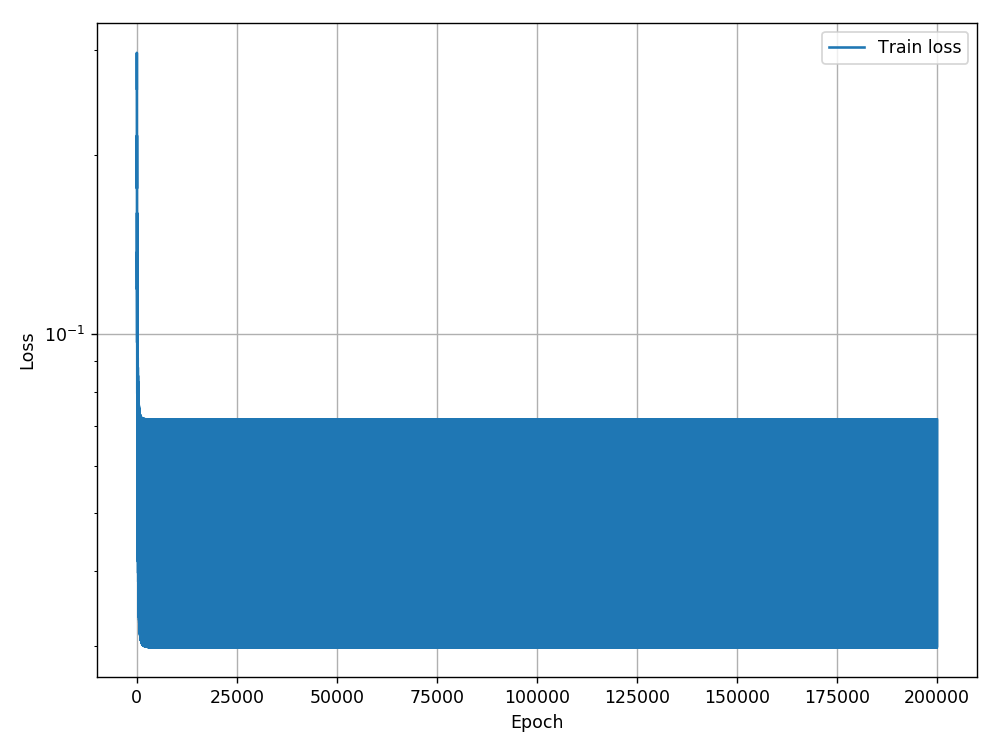

tensor(0.0719, device='cuda:0')


In [47]:
plt.close('all')
plt.figure(figsize=(8,6))
plt.semilogy(train_loss,label='Train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show
print (loss.data)

In [51]:
net.eval()
n_eval = 2
#s contains the shape of dataset
result = np.zeros((n_eval,s[0]-1,s[2],s[3]))

# Result and true should be the same 
# squeeze remove single-dimensional entries from the shape of an array
for count, data in enumerate(dataset1):        
    result[count,:,:,:] = net(data[:-1,:,:,:]).to('cpu').detach().numpy().squeeze()


In [52]:
result.shape

(2, 19, 10, 10)

<IPython.core.display.Javascript object>


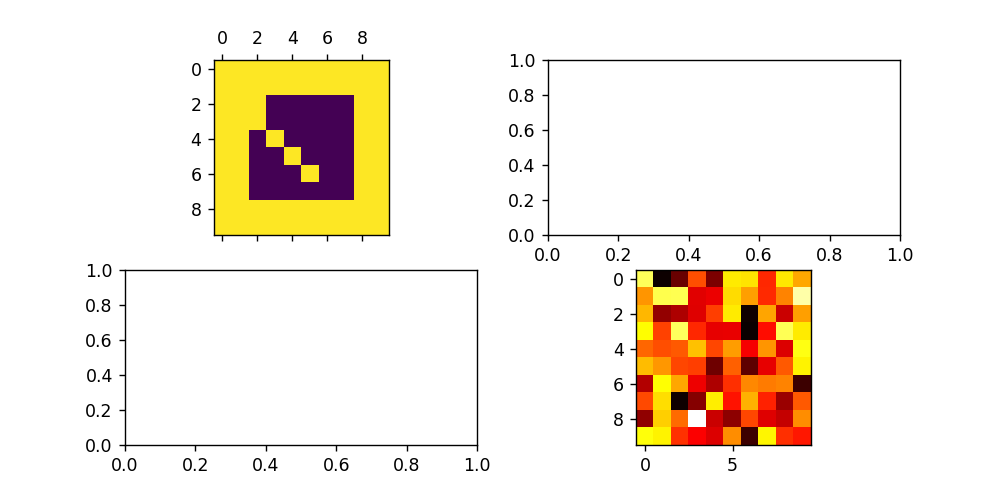

In [54]:
%matplotlib notebook
def generate_data(i):
    return d[i]#,d[i,1],d[i,2]

def updateplot(data):
    mat.set_data(data)
    #mat1.set_data(data[1])
    #mat2.set_data(data[2])
    #mat3.set_data(data[3])
    return mat#,mat1,mat2

def data_gen():
    global i
    while True:
        i = i+1
        yield generate_data(i)
i=0 #tick iterator
fig, (axes) = plt.subplots(nrows=2, ncols=2,figsize=(8, 4))
d = result[0]
mat = axes[0,0].matshow(generate_data(0))
#mat1 = axes[0,1].matshow(generate_data(0)[1])
#mat2 = axes[1,0].matshow(generate_data(0)[2])
axes[1,1].imshow(D[0,0,0], interpolation='nearest', cmap=plt.cm.hot)
#mat3 = axes[1,1].matshow(generate_data(0)[3], cmap=plt.cm.hot)
anim=animation.FuncAnimation(fig,updateplot,data_gen(),interval=5000,save_count=25)

<IPython.core.display.Javascript object>


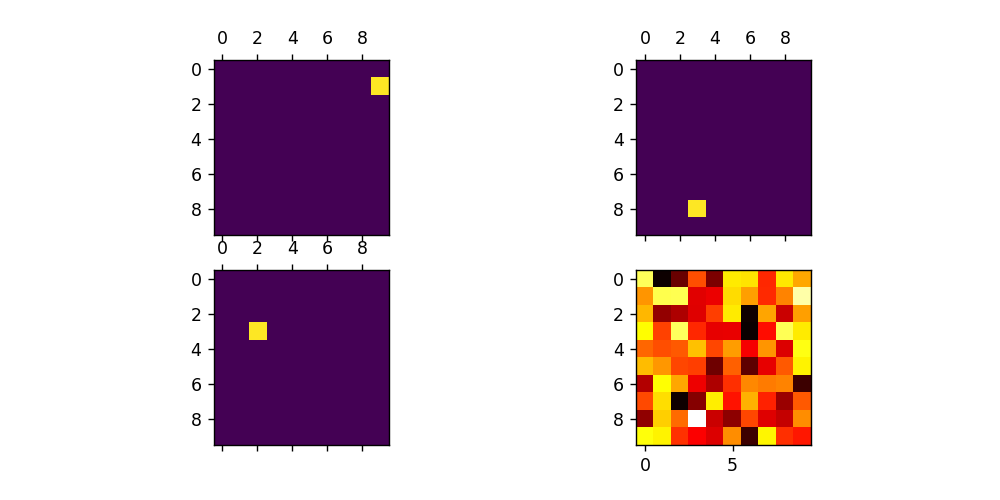

In [27]:
%matplotlib notebook
def generate_data(i):
    return d[i,1],d[i,2],d[i,3]

def updateplot(data):
    mat.set_data(data[0])
    mat1.set_data(data[1])
    mat2.set_data(data[2])
    #mat3.set_data(data[3])
    return mat,mat1,mat2

def data_gen():
    global i
    while True:
        i = i+1
        yield generate_data(i)
i=0 #tick iterator
fig, (axes) = plt.subplots(nrows=2, ncols=2,figsize=(8, 4))
d = D[0]
mat = axes[0,0].matshow(generate_data(0)[0])
mat1 = axes[0,1].matshow(generate_data(0)[1])
mat2 = axes[1,0].matshow(generate_data(0)[2])
axes[1,1].imshow(D[0,0,0], interpolation='nearest', cmap=plt.cm.hot)
#mat3 = axes[1,1].matshow(generate_data(0)[3], cmap=plt.cm.hot)
anim=animation.FuncAnimation(fig,updateplot,data_gen(),interval=2000,save_count=25)